<a href="https://colab.research.google.com/github/haydenkirkeide/Data-Mining-Final-Project/blob/main/K_means_SYNTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-403394176.py:34: SyntaxWarning: invalid escape sequence '\$'
  df_trips['costUSD'] = df_trips['costUSD'].replace({'\$': '', ',': ''}, regex=True).astype(float)


Demographic data loaded successfully.
Trip data loaded successfully.

Shopping data aggregated per user (synthID).
   synthID  total_cost  avg_time_mins  total_items  num_trips
0   S#001       126.80           24.0           10          1
1   S#002       352.81          112.0           17          1
2   S#003       288.31           31.0           35          3
3   S#004       195.83           21.5           25          2
4   S#005        97.39           28.0            5          1

Merged DataFrame size: 41 unique users.


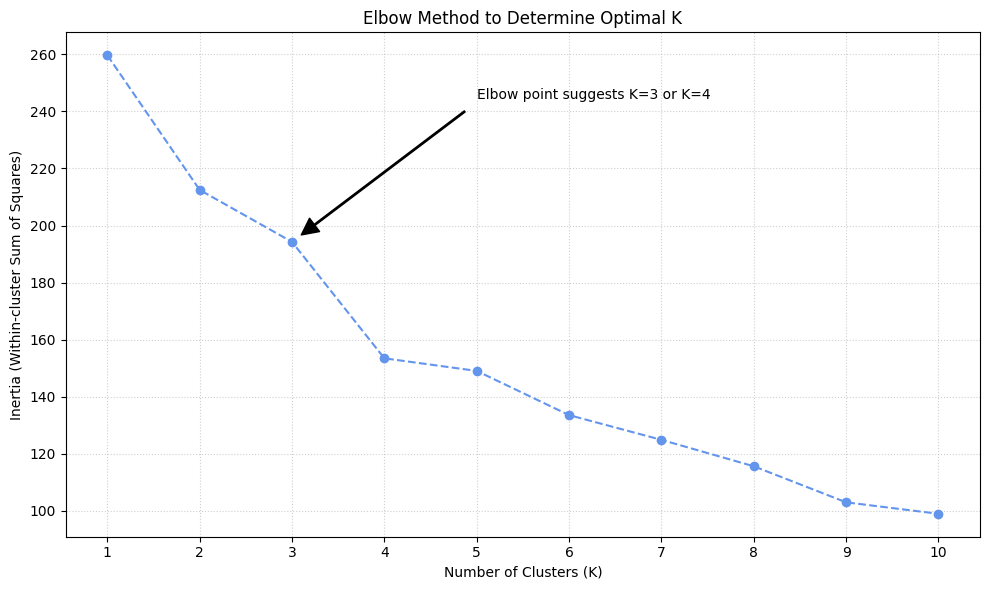



Elbow Method complete. Based on the graph, K=3 or K=4 appears optimal.

Running K-Means with optimal K = 4...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


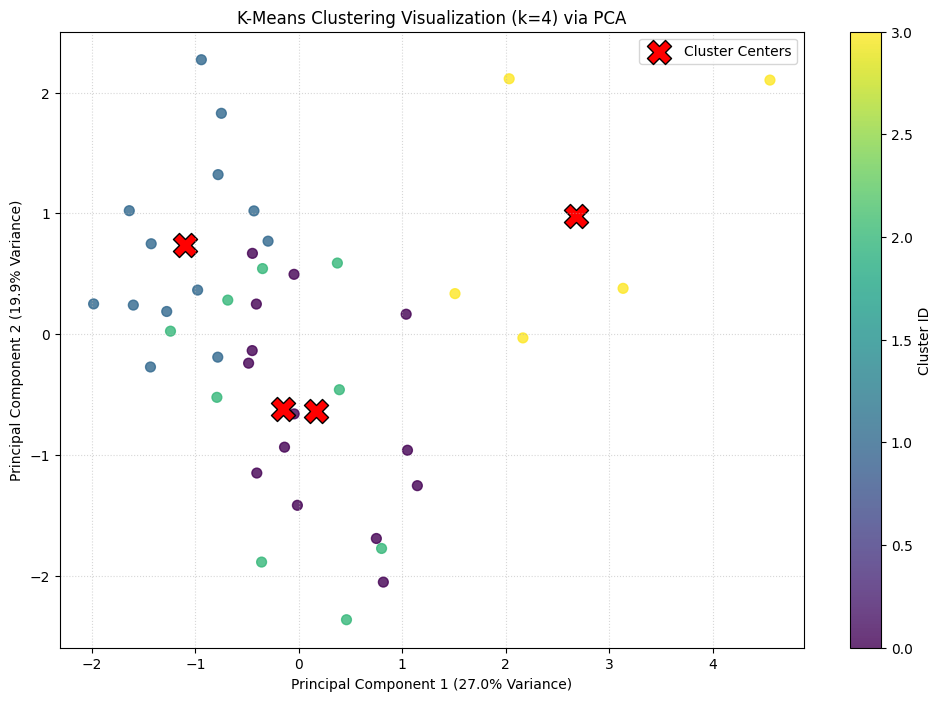



Visualization complete. The plot shows the 4 clusters separated in the two most informative dimensions (PC1 and PC2).

--- Cluster Analysis (Mean Attributes by Cluster) ---
|   Cluster |   total_cost |   avg_time_mins |   total_items |   num_trips | age   | employed   | membership   | freq    |   Size |
|----------:|-------------:|----------------:|--------------:|------------:|:------|:-----------|:-------------|:--------|-------:|
|         0 |       159.49 |           57.5  |         21.43 |         1   | 18–19 | pt         | Yes          | monthly |     14 |
|         1 |       167.26 |           88.69 |          8.15 |         1   | 22–23 | pt         | Yes          | monthly |     13 |
|         2 |       172.61 |           54.44 |         14.78 |         1   | 20–21 | pt         | No           | never   |      9 |
|         3 |       342.8  |           64.37 |         25    |         2.2 | 20–21 | no         | Yes          | monthly |      5 |

--- Cluster Interpretation Examp

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA # Import PCA for dimensionality reduction
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Loading ---

# Load the demographic data (Primary Survey)
try:
    df_survey = pd.read_csv("OPT SYNTH Standardized Preliminary Survey - Sheet1.csv")
    # CRITICAL FIX: Strip whitespace from column names to prevent KeyError
    df_survey.columns = df_survey.columns.str.strip()
    print("Demographic data loaded successfully.")
except FileNotFoundError:
    print("Error: 'OPT SYNTH Standardized Preliminary Survey - Sheet1.csv' not found.")
    exit()

# Load the trip data (Trip-by-Trip)
try:
    df_trips = pd.read_csv("OPT SYNTH Randomized Trip-by-Trip.csv")
    # CRITICAL FIX: Strip whitespace from column names to prevent KeyError
    df_trips.columns = df_trips.columns.str.strip()
    print("Trip data loaded successfully.")
except FileNotFoundError:
    print("Error: 'OPT SYNTH Randomized Trip-by-Trip.csv' not found.")
    exit()

# --- 2. Data Cleaning and Aggregation ---

# Clean 'costUSD' in trips data: remove '$', ',', and convert to float
df_trips['costUSD'] = df_trips['costUSD'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Aggregate shopping attributes per user (synthID)
df_shopping_aggregated = df_trips.groupby('synthID').agg(
    total_cost=('costUSD', 'sum'),
    avg_time_mins=('time_mins', 'mean'),
    total_items=('items', 'sum'),
    num_trips=('synthID', 'size')
).reset_index()

print("\nShopping data aggregated per user (synthID).")
print(df_shopping_aggregated.head())

# --- 3. Merging Datasets ---

# Merge demographic data with aggregated shopping data
# We use a 'left' merge to ensure we keep all users from the survey data,
# even if they somehow had no trips (though unlikely in this synthetic dataset).
df_merged = pd.merge(df_survey, df_shopping_aggregated, on='synthID', how='inner')
print(f"\nMerged DataFrame size: {df_merged.shape[0]} unique users.")

# --- 4. Feature Selection and Preprocessing ---

# Features to be used for clustering (a mix of demographics and shopping attributes)
features = [
    'age', 'employed', 'membership', 'freq',
    'total_cost', 'avg_time_mins', 'total_items', 'num_trips'
]
df_clustering = df_merged[features].copy()

# Identify Categorical and Numerical features
categorical_features = ['age', 'employed', 'membership', 'freq']
numerical_features = ['total_cost', 'avg_time_mins', 'total_items', 'num_trips']

# Handle Missing Values (Imputation - though usually unnecessary for well-formed synthetic data)
# Fill missing numerical data with the mean
imputer_num = SimpleImputer(strategy='mean')
df_clustering[numerical_features] = imputer_num.fit_transform(df_clustering[numerical_features])

# Fill missing categorical data with the most frequent value (mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
df_clustering[categorical_features] = imputer_cat.fit_transform(df_clustering[categorical_features])

# Encoding Categorical Variables (One-Hot Encoding for K-Means)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_clustering[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df_clustering.index)

# Combine numerical and encoded categorical features
X = pd.concat([df_clustering[numerical_features], df_encoded], axis=1)

# Scaling Numerical Features (Crucial for K-Means)
scaler = StandardScaler()
X_scaled = X.copy()
# Only scale the columns that were originally numerical
X_scaled[numerical_features] = scaler.fit_transform(X_scaled[numerical_features])

# --- 5. Determine Optimal K (Elbow Method) ---

inertia = []
# Test K values from 1 to 10
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='cornflowerblue')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(k_range)
plt.annotate('Elbow point suggests K=3 or K=4', xy=(3, inertia[2]), xytext=(5, inertia[2] + 50),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))
plt.tight_layout()
plt.show()
print("\n")
print("Elbow Method complete. Based on the graph, K=3 or K=4 appears optimal.")
optimal_k = 4 # Choosing 4 for a more detailed segmentation

# --- 6. K-Means Clustering ---

print(f"\nRunning K-Means with optimal K = {optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_merged['Cluster'] = kmeans.fit_predict(X_scaled)

# --- 7. Cluster Analysis and Visualization ---

# --- Dimensionality Reduction (PCA) for Visualization ---
# Project the high-dimensional scaled data onto 2 principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_merged['Cluster'].values

# Calculate cluster centers in the 2D PCA space
pca_cluster_centers = pca.transform(kmeans.cluster_centers_)

# Plot the Clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', s=50, alpha=0.8)

# Plot the cluster centers
plt.scatter(pca_cluster_centers[:, 0], pca_cluster_centers[:, 1], marker='X', s=300, c='red', label='Cluster Centers', edgecolors='black')

plt.title(f'K-Means Clustering Visualization (k={optimal_k}) via PCA')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)')
plt.colorbar(scatter, label='Cluster ID')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

print("\n")
print("Visualization complete. The plot shows the 4 clusters separated in the two most informative dimensions (PC1 and PC2).")

print("\n--- Cluster Analysis (Mean Attributes by Cluster) ---")

# Calculate the mean of numerical features per cluster
cluster_summary_num = df_merged.groupby('Cluster')[numerical_features].mean().reset_index()

# Calculate the mode/frequency of categorical features per cluster
cluster_summary_cat = {}
for cat in categorical_features:
    # Get the mode (most frequent value) for each cluster
    mode_series = df_merged.groupby('Cluster')[cat].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A')
    cluster_summary_cat[cat] = mode_series

df_summary_cat = pd.DataFrame(cluster_summary_cat)
df_summary = pd.merge(cluster_summary_num, df_summary_cat, on='Cluster')

# Count the size of each cluster
cluster_sizes = df_merged['Cluster'].value_counts().sort_index().reset_index()
cluster_sizes.columns = ['Cluster', 'Size']
df_summary = pd.merge(df_summary, cluster_sizes, on='Cluster')

# Print the final summary
print(df_summary.round(2).to_markdown(index=False))

# Interpretation of clusters
print("\n--- Cluster Interpretation Example ---")
print(f"Total Users Clustered: {df_merged.shape[0]}")
for i in range(optimal_k):
    cluster = df_summary.iloc[i]
    print(f"\nCluster {i} (Size: {cluster['Size']}):")
    print(f"   - Avg Total Spend: ${cluster['total_cost']:.2f}")
    print(f"   - Key Demographic: Age {cluster['age']}, Employment {cluster['employed']}, Membership: {cluster['membership']}")
    print(f"   - Shopping Frequency: {cluster['freq']}")
    print(f"   - Trip Characteristics: Avg Time {cluster['avg_time_mins']:.1f} mins, Avg Items {cluster['total_items']:.0f} total items across all trips.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')